# Comparison of inferred Rt profiles when using time-independent priors versus adding temporal dependency on the prior of Rt

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from cmdstanpy import CmdStanModel, cmdstan_path
import arviz as az
import nest_asyncio
import seaborn as sns
nest_asyncio.apply()

num_timepoints = 100 # number of days for incidence data
num_categories = 2

In [2]:
# # Read contact matrix
# cm_file = 'UK'
# path = os.path.join('../data_library/contact_matrix', '{}.csv'.format(cm_file))
# contact_matrix = pd.read_csv(path, header=None)

# # Read serial interval
# si_file = 'si-epinow'
# path = os.path.join('../data_library/serial_interval', '{}.csv'.format(si_file))
# serial_interval = pd.read_csv(path, header=None)
# serial_interval = serial_interval.fillna(0)
# serial_intervals = serial_interval.values.T

# # Read transmissibility vector
# trans_file = 'UK'
# path = os.path.join('../data_library/transmissibility', '{}.csv'.format(trans_file))
# transmissibility = pd.read_csv(path, header=None)

In [3]:
# # Read Ontario data
# path = os.path.join('../data_library/covid_ontario/ON.csv')
# data = pd.read_csv(path)[:51]

## Parameterize example branching process model with disagregated data

In [4]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

# Simulate incidence data
initial_r = 2
serial_interval = disc_w

# contact_matrix = contact_matrix
contact_matrix = np.array([[1, 0.5], [0.3, 0.4]])
# contact_matrix = 1 * np.ones((2, 2))

transmissibility = [0.5, 1.2]
# transmissibility = [1.5, 1.5]

m = branchpro.MultiCatPoissonBranchProModel(
    initial_r, serial_interval, num_categories, contact_matrix, transmissibility)
new_rs = np.linspace(2, 0.5, 20, endpoint=True).tolist() + np.linspace(0.5, 2.5, 15, endpoint=True).tolist()[1:]        # sequence of R_0 numbers
start_times = [0] + np.arange(28, 47).tolist() +  np.arange(66, 80).tolist()   # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = [50, 50] # initial number of cases
times = np.arange(num_timepoints)

desagg_cases = m.simulate(parameters, times)
agg_cases = np.sum(desagg_cases, axis=1)

print(desagg_cases)

[[5.000e+01 5.000e+01]
 [0.000e+00 0.000e+00]
 [3.400e+01 1.500e+01]
 [3.700e+01 3.300e+01]
 [3.800e+01 1.900e+01]
 [4.900e+01 1.600e+01]
 [6.000e+01 2.800e+01]
 [7.100e+01 3.500e+01]
 [5.000e+01 5.000e+01]
 [8.100e+01 4.000e+01]
 [8.900e+01 5.200e+01]
 [1.290e+02 6.100e+01]
 [1.420e+02 5.700e+01]
 [1.440e+02 7.000e+01]
 [1.950e+02 7.500e+01]
 [2.080e+02 1.000e+02]
 [2.280e+02 1.010e+02]
 [2.400e+02 1.250e+02]
 [3.160e+02 1.510e+02]
 [3.280e+02 1.640e+02]
 [3.550e+02 1.930e+02]
 [4.300e+02 2.160e+02]
 [4.890e+02 2.410e+02]
 [5.450e+02 2.640e+02]
 [6.280e+02 3.170e+02]
 [7.230e+02 3.310e+02]
 [8.590e+02 4.010e+02]
 [9.590e+02 4.340e+02]
 [1.106e+03 4.600e+02]
 [1.141e+03 5.870e+02]
 [1.265e+03 6.060e+02]
 [1.388e+03 6.970e+02]
 [1.495e+03 7.290e+02]
 [1.542e+03 7.330e+02]
 [1.606e+03 7.930e+02]
 [1.587e+03 7.840e+02]
 [1.541e+03 7.400e+02]
 [1.628e+03 7.570e+02]
 [1.527e+03 7.230e+02]
 [1.384e+03 6.540e+02]
 [1.260e+03 6.260e+02]
 [1.189e+03 5.040e+02]
 [1.017e+03 4.590e+02]
 [8.200e+02

## Plot agreggated local incidence numbers

In [5]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=agg_cases,
        name='Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## R_t inference using STAN

In [6]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5
sigma = 1.5

phi_mean = 0.5
phi_var = 10**(-0)
phi_rate = phi_var / phi_mean
phi_shape = phi_mean / phi_rate

# Naive correction for reproduction number per individual
# i.e. no variation in contacts and transmissibility between different categories
N_corr = num_categories * (np.sum(np.matmul(contact_matrix, transmissibility))/np.sum(contact_matrix))

# True correction - only available when we have desaggreagted case data
T_corr = np.empty(num_timepoints - R_t_start)

for _, t in enumerate(np.arange(R_t_start, num_timepoints)):
    T_corr[_] = np.sum(np.matmul(
                    contact_matrix,
                    np.multiply(
                        transmissibility,
                        m._effective_no_infectives(t, desagg_cases)
                    )))/ np.sum(m._effective_no_infectives(t, desagg_cases))

In [8]:
# Transform our incidence data into pandas dataframes
multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

for _ in range(num_categories):
    multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
        desagg_cases[:, _]

multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': agg_cases
    }
)

L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, start_times[2]+1))
L3 = len(np.arange(start_times[2]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': m.get_r_profile().tolist()[(R_t_start-1):]
})

## Time dependent Rt prior

In [9]:
t_dep_poisson_model = CmdStanModel(stan_file=os.path.join(
        '../../stan_models/t_dep_poisson_one.stan'))

t_dep_poisson_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_12111/766572806.py:55: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [10]:
fit = t_dep_poisson_model.sample(
    data=t_dep_poisson_model, seed=10, chains=3, iter_sampling=1000)

samples = az.from_cmdstanpy(fit)

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2801/6000)
Samp

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   1.793  0.088   1.626    1.949      0.001    0.001    4440.0    2575.0   
R[1]   1.730  0.072   1.598    1.869      0.001    0.001    5169.0    2332.0   
R[2]   1.665  0.068   1.531    1.787      0.001    0.001    4418.0    1992.0   
R[3]   1.600  0.061   1.485    1.716      0.001    0.001    4622.0    2109.0   
R[4]   1.650  0.058   1.546    1.765      0.001    0.001    4578.0    2314.0   
...      ...    ...     ...      ...        ...      ...       ...       ...   
R[88]  1.967  0.067   1.846    2.097      0.001    0.001    4508.0    2511.0   
R[89]  2.002  0.062   1.876    2.109      0.001    0.001    5324.0    1969.0   
R[90]  1.991  0.057   1.889    2.099      0.001    0.001    4508.0    2186.0   
R[91]  2.000  0.049   1.909    2.095      0.001    0.001    4582.0    2200.0   
R[92]  1.992  0.046   1.908    2.077      0.001    0.000    5772.0    2176.0   

       r_hat  
R[0]    1.00  
R[1]    1.00  
R[2]    1.00  
R[3]    1.01  
R[4]    1.00  
...      ...  
R[88]   1.00  
R[89]   1.00  
R[90]   1.00  
R[91]   1.00  
R[92]   1.00  

[93 rows x 9 columns]

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

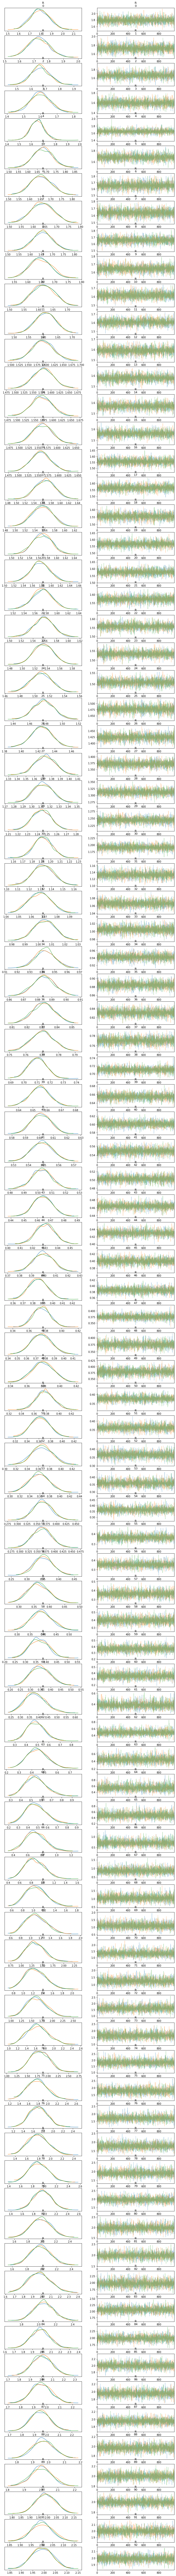

In [11]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [12]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit.draws()[500:, :, 7:]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, 0, :],
    chain_samples[:, 1, :],
    chain_samples[:, 2, :]), axis=0)

thinning = max(1, int(n_sample * n_chains / 500))

N_t_dep_pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0)/N_corr,
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0)/N_corr,
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0)/N_corr,
    'Central Probability': (num_timepoints - R_t_start) * [0.95]
})

T_t_dep_pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.divide(np.mean(extended_samples[::thinning, :], axis=0), T_corr),
    'Lower bound CI': np.divide(np.quantile(extended_samples[::thinning, :], 0.025, axis=0), T_corr),
    'Upper bound CI': np.divide(np.quantile(extended_samples[::thinning, :], 0.975, axis=0), T_corr),
    'Central Probability': (num_timepoints - R_t_start) * [0.95]
})

## Time independent Rt prior

In [19]:
t_ind_poisson_model = CmdStanModel(stan_file=os.path.join(
        '../../stan_models/t_inf_poisson_one.stan'))

t_ind_poisson_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_12111/112015315.py:54: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [20]:
fit = t_ind_poisson_model.sample(
    data=t_ind_poisson_model, seed=10, chains=3, iter_sampling=1000)

samples = az.from_cmdstanpy(fit)

az.summary(samples)

Building...

In file included from /Users/ioaros/Library/Caches/httpstan/4.10.1/models/apftn573/model_apftn573.cpp:2:
In file included from /Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^
In file included from /Users/ioaros/Library/Caches/httpstan/4.10.1/mode

ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-10.9-x86_64-cpython-39/Users/ioaros/Library/Caches/httpstan/4.10.1/models/apftn573/model_apftn573.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::P2' from file 'build/temp.macosx-10.9-x86_64-cpython-39/Users/ioaros/Library/Caches/

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   1.792  0.087   1.625    1.950      0.001    0.001    3625.0    2250.0   
R[1]   1.732  0.076   1.591    1.867      0.001    0.001    3836.0    2507.0   
R[2]   1.665  0.067   1.544    1.797      0.001    0.001    3585.0    2200.0   
R[3]   1.597  0.061   1.484    1.715      0.001    0.001    3701.0    2250.0   
R[4]   1.651  0.058   1.543    1.762      0.001    0.001    3170.0    2145.0   
...      ...    ...     ...      ...        ...      ...       ...       ...   
R[88]  1.966  0.066   1.849    2.099      0.001    0.001    3154.0    1815.0   
R[89]  2.000  0.061   1.881    2.108      0.001    0.001    3996.0    2102.0   
R[90]  1.991  0.055   1.894    2.102      0.001    0.001    3761.0    2046.0   
R[91]  1.999  0.050   1.907    2.094      0.001    0.001    3813.0    2237.0   
R[92]  1.992  0.045   1.912    2.080      0.001    0.001    3279.0    2211.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
...      ...  
R[88]    1.0  
R[89]    1.0  
R[90]    1.0  
R[91]    1.0  
R[92]    1.0  

[93 rows x 9 columns]

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

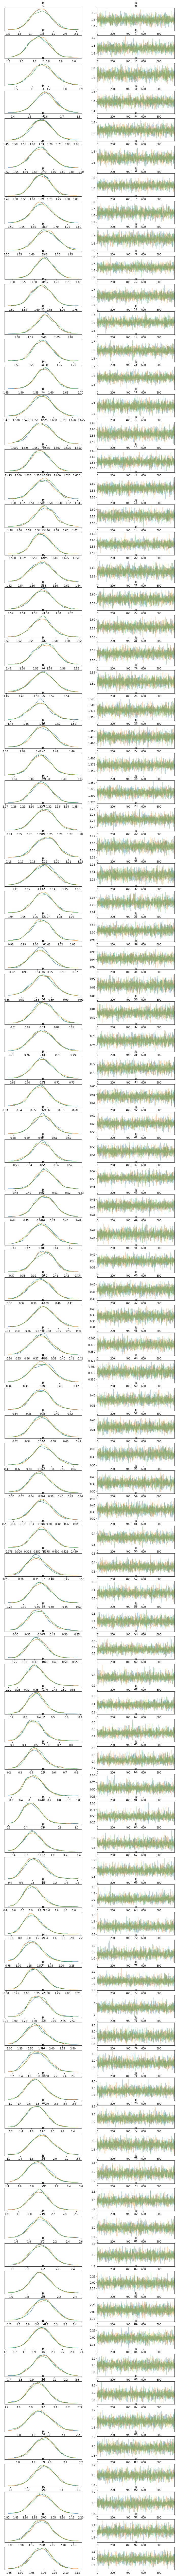

In [21]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [22]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit.draws()[500:, :, 7:]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, 0, :],
    chain_samples[:, 1, :],
    chain_samples[:, 2, :]), axis=0)

thinning = max(1, int(n_sample * n_chains / 500))

N_t_ind_pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0)/N_corr,
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0)/N_corr,
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0)/N_corr,
    'Central Probability': (num_timepoints - R_t_start) * [0.95]
})

T_t_ind_pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.divide(np.mean(extended_samples[::thinning, :], axis=0), T_corr),
    'Lower bound CI': np.divide(np.quantile(extended_samples[::thinning, :], 0.025, axis=0), T_corr),
    'Upper bound CI': np.divide(np.quantile(extended_samples[::thinning, :], 0.975, axis=0), T_corr),
    'Central Probability': (num_timepoints - R_t_start) * [0.95]
})

## Inference plot using class method results

In [24]:
fig = ReproductionNumberPlot()

fig.add_interval_rt(N_t_dep_pois_intervals, colour='pink', shape='dash', model_type='poisson Naive correction term')
fig.add_interval_rt(T_t_dep_pois_intervals, colour='red', model_type='poisson True correction term')
fig.add_interval_rt(N_t_ind_pois_intervals, colour='deepskyblue', shape='dash', model_type='poisson Naive correction term')
fig.add_interval_rt(T_t_ind_pois_intervals, colour='blue', model_type='poisson True correction term')

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()